In [447]:
import numpy as np
import re
from mxnet import nd
import string
import copy
from matplotlib.pyplot import plot as plt

In [448]:
with open('/root/works/news.txt','r') as f:
    raw = f.read()

In [449]:
content = copy.deepcopy(raw)
r = "[_.!+-=——,$%^，。？、~@#￥%……&*《》<>「」{}【】()/\\n]"
content_wo_p = re.sub(r, '', content)
extracted_words = []
for word in content_wo_p.split(' '):
    if word!=' ' and word!= '':
        extracted_words.append(word)
words = list(set(extracted_words))

In [450]:
contents = re.sub(r,'',content)
wordsiter = contents.split(' ')

In [451]:
word2index = dict()
index2word = dict()
for idx, word in enumerate(words):
    word2index[word] = idx
    index2word[idx] = word

In [452]:
dataiter = dict()
window_size = 1
for idx in range(len(wordsiter)):
    dataiter[idx]=wordsiter[max(0,idx-window_size):idx]+wordsiter[idx+1:min(idx+1+window_size,len(wordsiter)-1)]

In [453]:
W_in = np.random.normal(0,1,size=(len(words),30))
W_out = np.random.normal(0,1,size=W_in.shape)

In [454]:
def softmax(v):
    return np.exp(v)/np.exp(v).sum()

In [455]:
def word2oh(word):
    word_oh = np.zeros(shape=(len(words)))
    word_oh[word2index[word]]=1
    return word_oh

In [456]:
W_in.shape

(117, 30)

In [457]:
def loss_fn(softmax_out, contexts):
    l = 0
    for context in contexts: 
        context_word_oh = word2oh(context)
        l += -np.log(np.dot(softmax_out,context_word_oh.T))
    return l


In [458]:
def gradiant_in(W_out, v_out, contexts):
    for context in contexts:
        context_oh = word2oh(context)
        o_n = np.dot(context_oh,W_in)
        exp_softmax_out= W_out.T*np.exp(v_out).reshape(1,117)/np.sum(np.exp(v_out))
        sum_eso = exp_softmax_out.sum(axis=1)
        g_in = -(o_n-sum_eso)
        return g_in

In [459]:
def gradiant_out(W_in,softmax_out, center, contexts):
    gradiants_out = []
    for context in contexts:
        context_oh = word2oh(context)
        i_m = W_in[word2index[center],:]
        p = np.dot(context_oh,softmax_out)
        gradiants_out.append((p-1)*i_m)
    return gradiants_out
        

In [460]:
def n_trainer(W_in, W_out, center, contexts, v_out, softmax_out, lr_in, lr_out):
    gs_out = gradiant_out(W_in, softmax_out, center,contexts)
    for g_out, context in zip(gs_out,contexts):
        W_out[word2index[context],:] = W_out[word2index[context],:]-lr_out*g_out

    g_in = gradiant_in(W_out,v_out,contexts)
    W_in[word2index[center],:] = W_in[word2index[center],:]-g_in*lr_in
    

In [461]:
epochs=1000
lr_in = 0.001
lr_out = 0.001
epoch_losses = []
words_count = len(wordsiter)


In [462]:
for epoch in range(epochs):
    epoch_loss= 0
    for idx in range(len(wordsiter)):
        center = wordsiter[idx]#中心词
        contexts = dataiter[idx]#背景词
        center_oh = word2oh(center)
        v_out = np.dot(np.dot(center_oh,W_in),W_out.T).reshape(-1)#c_i
        softmax_out = softmax(v_out)
        l = loss_fn(softmax_out, contexts)
        epoch_loss+=l
        n_trainer(W_in, W_out, center, contexts, v_out, softmax_out, lr_in,lr_out)
    print(epoch_loss/words_count)
    epoch_losses.append(epoch_loss/words_count)


        


30.211400418899736
30.01401953141101
29.818987518612584
29.626202154764236
29.43554182731418
29.246882774458307
29.06011478644795
28.875153905479394
28.691951930967477
28.510503290119225
28.33084994291839
28.153084551119907
27.9773513279689
27.803843032764746
27.63279186664253
27.46445218687198
27.299074699526386
27.13687530012641
26.978005792345023
26.822535615705547
26.670451030122095
26.521671500099526
26.37607627377247
26.233531536457605
26.09391084025141
25.957106186400388
25.823031028926387
25.691618121041525
25.562814863210054
25.43657769824046
25.3128660660135
25.19163595237142
25.072833192358747
24.95638718313214
24.842206152403506
24.730175249102324
24.620158283866406
24.5120030555942
24.405549231636456
24.30063713436264
24.19711575638746
24.094848802560918
23.993718254016283
23.893625574014624
23.794491061906157
23.69625199330313
23.598860134076244
23.502279076170062
23.40648168674787
23.311447829007236
23.21716241724129
23.123613809051506
23.03079250621754
22.93869012359648

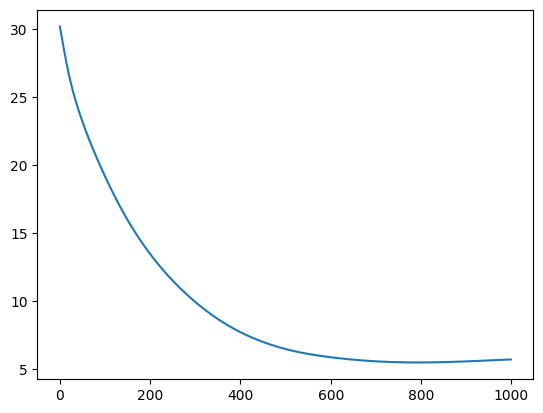

In [463]:
plt(range(len(epoch_losses)),epoch_losses)